<h3 align=right>Felix FIlipi</h3>
<h3 align=right>2301877590</h3>

<hr>
<h1 align=center>Computer VIsion</h1>
<h1 align="center"> Feature Detection and Matching </h1>

<hr>
Before we go any further, we should know what's the meaning of feature detection and feature matching.

<b>What does feature detection mean? </b>

So, feature detection means that we are going to detect a good feature that is invariant to the geometric transformation such as translation, rotation, etc, and also photometric transformation such as contrast, brightness, etc.

<b> But what's feature? </b>

Feature simply means that we are going to find a set of information that is relevant to solve a computational task, such as point, edge, and corner.

But, this feature usually refers to corner because corner is invariant to the geometric and photometric transformation.

The features that are in specific locations of the images, such as mountain peaks, etc are often called keypoint features (or even corners). Meanwhile the features that can be matched based on their orientation and local appearance are called edges

<b> Now, we know about feature detection, but feature matching?</b>

When feature detection simply means identifying the interest point (i.e Edges), feature matching is going to use all of this interest point to compare the similar features from the other image.


<h2>So, what is it used for?</h2>

* Object Tracking
* Compute disparity
* Recognition
* 3D reconstruction
* Robot Navigation
* Etc.



<b>Algorithm For Feature Detection And Matching</b>

1. Find a set of distinctive keypoints
2. Define a region around each keypoint
3. Extract and normalize the region content
4. Compute a local descriptor from the normalized region
5. Match local descriptors

So, let's go deeper into our experiment, we are asked to demonstrate detailed steps of finding interest points using Harris corner on 2 images, and perform image matching into it. Also, we asked to compare cv2.BFMatcher and cv2.FLANN, but here I want to do several experiments to know what will happen if we do this from several different angles or even different houses.

So, let's go jump into the code. First, import the library.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

<h3> Harris Corner </h3>

The idea is to consider a small window around each pixel p in an image. We want to identify all such pixel windows that are unique. Uniqueness can be measured by shifting each window by a small amount in a given direction and measuring the amount of change that occurs in the pixel values.

we take the sum squared difference (SSD) (also known as squared euclidean distance) of the pixel values before and after the shift and identifying pixel windows where the SSD is large for shifts in all 8 directions.

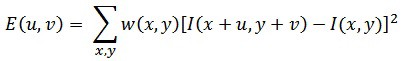

where u,v are the x,y coordinates of every pixel in our 3 x 3 window and I is the intensity value of the pixel. The features in the image are all pixels that have large values of E(u,v), as defined by some threshold and we have to maximize this function E(u,v) for corner detection.

So, we can achieve it by implements Taylor expansion to the equation, and after some mathematical operation, we get the final equation as:

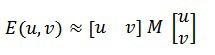

Where M stands for:

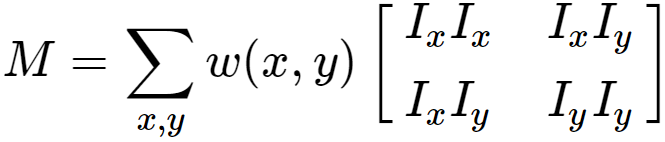

But it's not over yet, the response of the corner detector is obtained, using this formula:

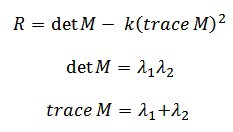

Depend on the value obtained by this formula, we can determine if a region determined as a flat, edge or a corner.

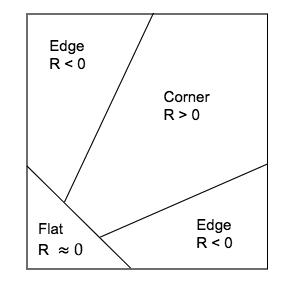

Here's the simple pseudocode:

1. Grayscale the original image

2. Apply a Gaussian filter

3. Apply Sobel operator to find the x and y gradient values for every pixel in the grayscale image

4. For each pixel in the grayscale image, convolve 3×3 window and compute the corner strength function.

5. Threshold the output pixels to prevent redundant duplicate of features.

6. For each pixel that meets the criteria in 5, compute a feature descriptor.


<b>We know the concept just now, seems complicated right?? So, let's try to implement it with code to simplify it.

In [2]:
# 1. Grayscale the original image

def load_image(img):
    ds = cv2.imread(img)
    ds = cv2.resize(ds, (400,250))
    gray = cv2.cvtColor(ds, cv2.COLOR_BGR2GRAY)
    return ds, gray


# 2. Apply a Gaussian filter

def gauss_blur(image, ksize, sigma = 1): #set default sigma 1
        
    normalization = 1 / (2 * np.pi * sigma**2)
    
    #split mgrid to make sure kernel have its true size
    ksize = round(ksize//2) 
    
    #generate 2D kernel with different direction (i horizontal, j vertical) between kernel size 
    #The i variable for (i-(k+1)) and j variable for (j-(k+1)) 
    i, j = np.mgrid[-ksize:ksize+1, -ksize:ksize+1] 

    #Generated gaussian kernel from formula
    kernel =  normalization * np.exp(-((i**2 + j**2) / (2*sigma**2))).flatten() #flatten to convolve

    #Convolve the kernel to image
    flat_image = image.flatten()
    res = np.convolve(flat_image,kernel,"same") #np.convolve works in 1D arr
    res = np.reshape(res,(image.shape)) #return as its true 2D arr to visualize it
    res= np.uint(res)
    return res


# 3. Apply Sobel operator to find the x and y gradient values for every pixel in the grayscale image

def sobel_gradient(img):
    
    #Define the sobel_kernel
    X_kernel = np.array(
        [-1,0,1,
         -2,0,2,
         -1,0,1]) #plot in 1D, because we are going to use np.convolve
    
    Y_kernel = np.array(
        [1,2,1,
         0,0,0,
         -1,-2,-1]) #plot in 1D, because we are going to use np.convolve
    
    #convert image to 1D before convolve
    img_flatten = img.flatten()
    #Convolve each direction
    X_convolve = np.convolve(img_flatten,X_kernel,"same")
    Y_convolve = np.convolve(img_flatten,Y_kernel,"same")
    
    #Return to its true form
    dx = np.reshape(X_convolve,(img.shape))
    dy = np.reshape(Y_convolve,(img.shape))
    
    gradient = [dx,dy]
    
    return gradient


# unfortunately won't be implemented in this code because this code keeps crashing my computer.
def harris_corner(img, threshold, ksize = 3, k = 0.05):
    
    corners = []
    output_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2RGB)
    
    offset = int(ksize/2)
    y_range = img.shape[0] - offset
    x_range = img.shape[1] - offset
    
    # Structure tensor
    dy, dx = np.gradient(img)
    Ixx = np.square(dx)
    Iyy = np.square(dy)
    Ixy = dx * dy
    
    
    # 4. For each pixel in the grayscale image, convolve 3×3 window and compute the corner strength function.
    
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            
            # set sliding windows value / kernel start-end
            x_start = x - offset
            x_end = x + offset + 1
            
            y_start = y - offset
            y_end = y + offset + 1
            
            # sum of square
            Sxx = np.sum(Ixx[y_start:y_end, x_start:x_end])
            Syy = np.sum(Iyy[y_start:y_end, x_start:x_end])
            Sxy = np.sum(Ixy[y_start:y_end, x_start:x_end])
            
            
            # To get corner response we need to find its determinant and trace
            det = (Ixx * Ixy) - (Ixy ** 2) # determinant
            trace = Ixx + Iyy # trace
    
            # formula can be seen in above explanation
            response = det - k * (trace ** 2)
            
            # 5. Threshold the output pixels to prevent redundant duplicate of features.
            print(output)
            print(output_img.shape)
            if (response > threshold).any():
                
                corners.append([x, y, response])
                output_img.itemset((x, y, 0), 0)
                output_img.itemset((x, y, 1), 255)
                output_img.itemset((x, y, 2), 0)
    
    return output_img, corners

def visualize(img_list, title_list):
    plt.figure(figsize=(15,15))
    for i in range(len(img_list)):
        plt.subplot(5,3,i+1)
        plt.imshow(img_list[i],cmap="gray")
        plt.xticks([]), plt.yticks([])
        plt.title(title_list[i])

That's all functions we need to use for harris corner detection. Let's try it

<b>*Note: I'm trying to implement harris_corner code from scratch but it doesn't work well and keeps my computer crashing. So, to avoid more severe computer damage from my computer, I made a tough decision with forgetting to make this code from scratch and will try an easier way to implement the harris corner using OpenCV. I don't know what's wrong with the code above, but I do believe that we've done each step needed to create harris corner from scratch.

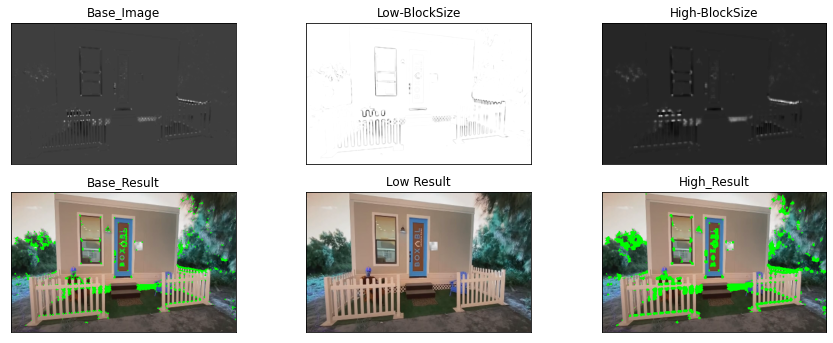

In [3]:
img, gray = load_image('1.jpg')
base_img = cv2.cornerHarris(gray, 3, 3, 0.05) #src, blockSize (neighbor size), ksize, k
blockSize_low = cv2.cornerHarris(gray, 1, 3, 0.05) # try to set the blockSize low
blockSize_high = cv2.cornerHarris(gray, 5, 3, 0.05) # try to set the blockSize high

base_res = img.copy() 
low_res = img.copy()
high_res = img.copy()

# The harris corner should be applied to the RGB images to be seen easier.
base_res[base_img > 0.01 * base_img.max()] = [0,255,0] 
low_res[blockSize_low > 0.01 * blockSize_low.max()] = [0,255,0]
high_res[blockSize_high > 0.01 * blockSize_high.max()] = [0,255,0]

img_list_1 = [base_img, blockSize_low, blockSize_high, base_res, low_res,high_res]
img_title_1 = ['Base_Image', 'Low-BlockSize', 'High-BlockSize', 'Base_Result','Low Result','High_Result']
visualize(img_list_1, img_title_1)

As we can see here, higher blockSize will return higher intensity of corner, so if you need a clean corner make sure that your blockSize is not too high. Now, let's try to implement the base image on the other set.

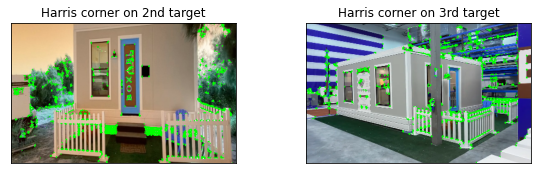

In [4]:
img_2, gray_2 = load_image('2.jpg')
img_3, gray_3 = load_image('3.jpeg')

target_img_2 = cv2.cornerHarris(gray_2, 3, 3, 0.05) #src, blockSize (neighbor size), ksize, k
target_img_3 = cv2.cornerHarris(gray_3, 3, 3, 0.05) #src, blockSize (neighbor size), ksize, k

# The harris corner should be applied to the RGB images to be seen easier.
img_2[target_img_2 > 0.01 * target_img_2.max()] = [0,255,0] 
img_3[target_img_3 > 0.01 * target_img_3.max()] = [0,255,0] 

img_list_2 = [img_2, img_3]
img_title_2 = ['Harris corner on 2nd target','Harris corner on 3rd target']
visualize(img_list_2, img_title_2)

Now we have implemented harris corner on both targets, let's go to the next step, matching the image. To do this first we need to detect the key points (to show where's the feature) and descriptor (to save the feature point), we can use any algorithm such as sift, surf, etc. But we will try to implement it using orb since it's the free version.

In [5]:
#-- Step 1: Detect the keypoints using ORB Detector, compute the descriptors
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(base_res, None)
keypoints2, descriptors2 = orb.detectAndCompute(img_2, None)
keypoints3, descriptors3 = orb.detectAndCompute(img_3, None)

Now, we have the keypoints and the descriptor, next we create a BFMatcher object with distance measurement cv2.NORM_HAMMING (since we are using ORB) and crossCheck is switched on for better results. Then we use Matcher.match() method to get the best matches in two images. We sort them in ascending order of their distances so that best matches (with low distance) come to front.

(([], []), ([], []))

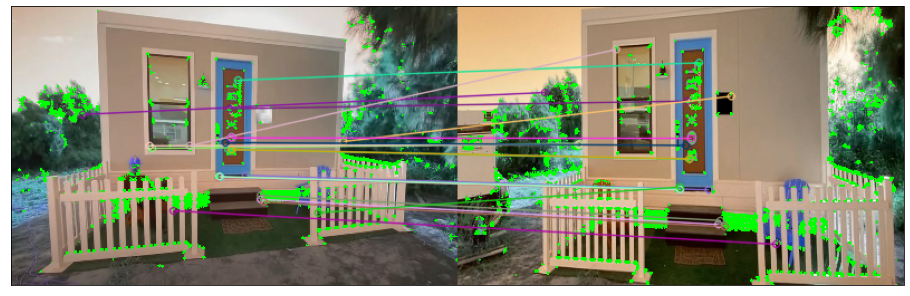

In [6]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches12 = bf.match(descriptors1,descriptors2)

# Sort them in the order of their distance.
matches12 = sorted(matches12, key = lambda x:x.distance)

# Draw matches
matches_angle = cv2.drawMatches(base_res,keypoints1,img_2,keypoints2,matches12[:20], None,flags=2)

plt.figure(figsize=(16,16))
plt.imshow(matches_angle)
plt.xticks([]), plt.yticks([])

We've try to implement feature matching on different angle images, and as we can see here, not all feature matched correctly, but this algorithm good enough to matching the feature oon different angles. But what will happen if we do this on different images?

(([], []), ([], []))

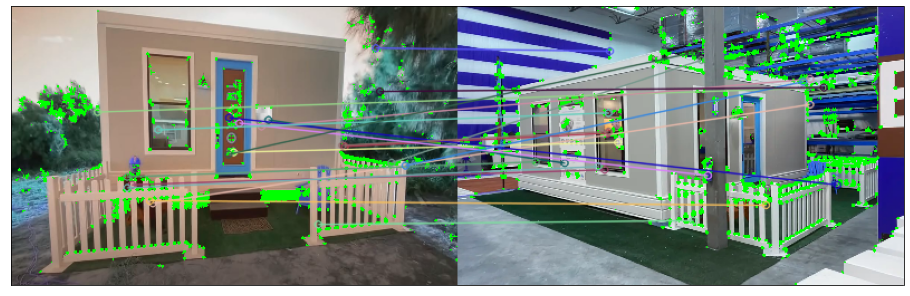

In [7]:
matches13 = bf.match(descriptors1,descriptors3)

# Sort them in the order of their distance.
matches13 = sorted(matches13, key = lambda x:x.distance)

# Draw matches
matches_angle = cv2.drawMatches(base_res,keypoints1,img_3,keypoints3,matches13[:20], None,flags=2)

plt.figure(figsize=(16,16))
plt.imshow(matches_angle)
plt.xticks([]), plt.yticks([])

We can see here on different images angle, feature matching doesn't work so well, but still have a good result since some feature matched properly.

Now, we also asked to compare this algorithm with FLANN (Fast Library for Approximate Nearest Neighbors), let's try it.

In [8]:
index_params= dict(algorithm = 6, # FLANN_INDEX_LSH
                   table_number = 12, # 12
                   key_size = 20,     # 20
                   multi_probe_level = 2) #2

search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(descriptors1,descriptors2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

for i,pair in enumerate(matches):
    try:
        m, n = pair
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            
    except ValueError:
        pass

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

(([], []), ([], []))

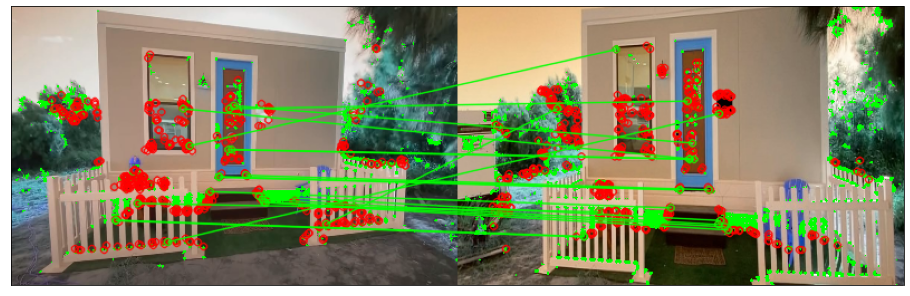

In [9]:
matches_angle_FLANN = cv2.drawMatchesKnn(base_res,keypoints1,img_2,keypoints2,matches,None,**draw_params)

plt.figure(figsize=(16,16))
plt.imshow(matches_angle_FLANN)
plt.xticks([]), plt.yticks([])

As we can see here, FLANN didn't perform so well compared to BFMatcher, so after a few tweaks and internet research, I found that FLANN is much faster than BFMatcher, but it only finds an approximate nearest neighbor, which is a good matching but not necessarily the best. Meanwhile, the brute force matcher is doing exactly the same as its name brute-forcing, it will perform slower but give better results instead.

I won't implement FLANN to the other images, because we've understand that FLANN not performing a good matching compared to brute force matcher. So, instead of reading some random matching for the next images, I think we can end this feature matching section.

<h2>So, here's some conclusion from the conducted research about feature matching </h2>

1. We've learned about the harris corner detection algorithm from scratch, we've tried to implement the code from scratch but I think there's some minor mistake from the code. I'm not going to repair it because troubleshooting it will make my computer crashing and damage my hard disk.
2. We've implemented the harris corner detection in an easier way using OpenCV library, and tweaking its parameter such as blockSize, and find that higher blockSize means the higher intensity of the pixel corner, so make sure to tweak this parameter carefully.
3. We've compared the image matching performance on different image locations which generate a little bit of random matching, but still give good enough results as a matcher.
4. We've performed brute force matcher and FLANN matcher and know that BFMatcher performs better on the accuracy of the result. Meanwhile, FLANN performs better for speed performance instead of brute-forcing methods.

<h2>So, that's all for this section, and thank you for watching